Numerical analytic continuation
===============================

One of the main problems one faces when working with imaginary (Euclidean) time is inferring the
real-time spectra $\rho(\omega)$ from imaginary-time data $G(\tau)$, in other words, we are
seeking the inverse of the following Fredholm equation:

$$
    G(\tau) = -\int d\omega\ K(\tau, \omega)\ \rho(\omega)
            = -\sum_{l=0}^\infty U_l(\tau)\ S_l \int d\omega\ V_l(\omega)\ \rho(\omega),
$$

where again $S_l$ are the singular values and $U_l(\tau)$ and $V_l(\omega)$ are the left and right
singular (IR basis) functions, the result of a singular value expansion of the kernel $K$.

Using the IR basis expansion, we can "invert" above equation to arrive at:

$$
    \rho(\omega) \sim -\int d\tau\ K^{-1}(\omega, \tau)\ G(\tau)
    = -\sum_{l=0}^\infty V_l(\omega)\ \frac 1{S_l} \int d\tau\ U_l(\tau)\ G(\tau),
$$

where $K^{-1}$ denotes the pseudoinverse of $K$.  (We will defer questions about the exact nature of this inverse.)  The numerical analytical continuation problem is now evident:  The kernel is regular, i.e., all the singular values $S_l > 0$, so the above equation can be evaluated analytically.  However, $S_l$ drop exponentially quickly, so any finite error, even simply the finite precision of $G(\tau)$ in a computer, will be arbitrarily amplified once $l$ becomes large enough.  We say the numerical analytical continuation problem is **ill-posed**.

In [1]:
import numpy as np
import matplotlib.pyplot as pl
import sparse_ir

In [2]:
beta = 40.0
wmax = 2.0
basis = sparse_ir.FiniteTempBasis('F', beta, wmax, eps=2e-8)

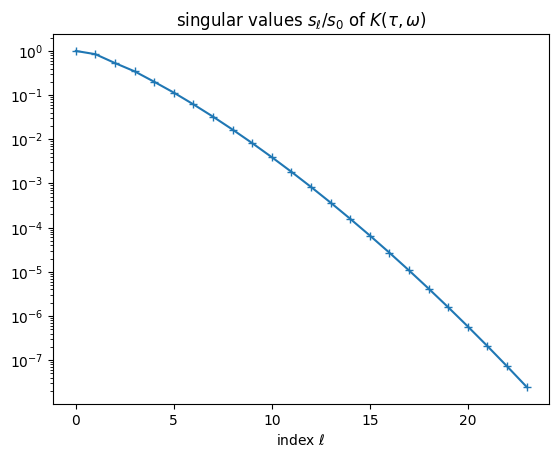

In [3]:
pl.semilogy(basis.s / basis.s[0], '-+')
pl.title(r'singular values $s_\ell/s_0$ of $K(\tau, \omega)$')
pl.xlabel(r'index $\ell$');

<!-- #region tags=[] -->
Least squares form
------------------
In order to make meaningful progress, let us reformulate the analytic continutation as a least squares problem:

$$
    \min_\rho \int d\tau\ \Big| G(\tau) + \int d\omega\ K(\tau, \omega)\ \rho(\omega) \Big|^2,
$$

To simplify and speed up this equation, we want to use the IR basis form of the kernel.
For this, remember that for any imaginary-time propagator:

$$
    G(\tau) = \sum_{l=0}^{L-1} g_l U_l(\tau) + \epsilon_L(\tau),
$$

where the error term $\epsilon_L$ drops as $S_L/S_0$.  We can now choose the basis cutoff $L$ large
enough such that the error term is consistent with the intrinsic accuracy of the $G(\tau)$, e.g.,
machine precision.  (If there is a covariance matrix, generalized least squares should be used.)  Since the IR basis functions $U_l$ form an isometry, we also have that:

$$
    \int\ d\tau\ |G(\tau)|^2 = \sum_{l=0}^{L-1} |g_l|^2 + O(\epsilon_L)
$$

allowing us to truncate our analytic continuation problem to (cf. [Jarrell and Gubernatis, 1996]):

$$
    \min_\rho \sum_{l=0}^{L-1} \Big| g_l + S_l \int d\omega\ V_l(\omega)\ \rho(\omega) \Big|^2.
    \qquad(1)
$$

This already is an improvement over many analytical continuation algorithms, as it maximally compresses the observed imaginary-time data $g_l$ without relying on any _a priori_ discretizations of the kernel.

[Jarrell and Gubernatis, 1996]: https://doi.org/10.1016/0370-1573(95)00074-7
<!-- #endregion -->

In [4]:
def semicirc_dos(w):
    return 2/np.pi * np.sqrt((np.abs(w) < wmax) * (1 - np.square(w/wmax)))

def insulator_dos(w):
    return semicirc_dos(8*w/wmax - 4) + semicirc_dos(8*w/wmax + 4)

# For testing, compute exact coefficients g_l for two models
rho1_l = basis.v.overlap(semicirc_dos)
rho2_l = basis.v.overlap(insulator_dos)
g1_l = -basis.s * rho1_l
g2_l = -basis.s * rho2_l

# Put some numerical noise on both of them (30% of basis accuracy)
rng = np.random.RandomState(4711)
noise = 0.3 * basis.s[-1] / basis.s[0]
g1_l_noisy = g1_l + rng.normal(0, noise, basis.size) * np.linalg.norm(g1_l)
g2_l_noisy = g2_l + rng.normal(0, noise, basis.size) * np.linalg.norm(g2_l)

TypeError: PiecewiseLegendrePolyVector.overlap() missing 2 required positional arguments: 'xmin' and 'xmax'

Truncated-SVD regularization
----------------------------
However, the problem is still ill-posed.  As a first attempt to cure it, let us turn to truncated-SVD regularization ([Hansen, 1987]), by demanding that the spectral function $\rho(\omega)$ is representable by the right singular functions:

$$
    \rho(\omega) = \sum_{l=0}^{L'-1} \rho_l V_l(\omega),
$$

where $L' \le L$.  The analytic continuation problem (1) then takes the following form:

$$
    \rho_l = -g_l / S_l.
$$

The choice of $L'$ is now governed by a bias–variance tradeoff: as we increase $L'$, more and more features of the spectral function emerge by virtue of $\rho_l$, but at the same time $1/S_l$ amplifies the stastical errors more strongly.

[Hansen, 1987]: https://doi.org/10.1007/BF01937276

In [ ]:
# Analytic continuation made (perhaps too) easy
rho1_l_noisy = g1_l_noisy / -basis.s
rho2_l_noisy = g2_l_noisy / -basis.s

In [ ]:
w_plot = np.linspace(-wmax, wmax, 1001)
Vmat = basis.v(w_plot).T
Lprime1 = basis.size // 2

def _plot_one(subplot, dos, rho_l, name):
    pl.subplot(subplot)
    pl.plot(w_plot, dos(w_plot), ":k", label="true")
    pl.plot(w_plot, Vmat[:, :Lprime1] @ rho_l[:Lprime1],
            label=f"reconstructed ($L' = {Lprime1}$)")
    pl.plot(w_plot, Vmat @ rho_l, lw=1,
            label=f"reconstructed ($L' = L = {basis.size}$)")
    pl.xlabel(r"$\omega$")
    pl.title(name)
    pl.xlim(-1.02 * wmax, 1.02 * wmax)
    pl.ylim(-.1, 1)

_plot_one(121, semicirc_dos, rho1_l_noisy, r"semi-elliptic DOS $\rho(\omega)$")
_plot_one(122, insulator_dos, rho2_l_noisy, r"insulating DOS $\rho(\omega)$")
pl.legend()
pl.gca().set_yticklabels([])
pl.tight_layout(pad=.1, w_pad=.1, h_pad=.1)

Regularization
--------------
Above spectra are, in a sense, the best reconstructions we can achieve without including
any more _a priori_ information about $\rho(\omega)$.  However, it turns out we often know
(or can guess at) quite a lot of properties of the spectrum:

 1. the spectrum must be non-negative, $\rho(\omega) \ge 0$, for one orbital,
    and positive semi-definite, $\rho(\omega) \succeq 0$, in general,

 2. the spectrum must be a density: $\int d\omega\ \rho(\omega) = 1$,

 3. one may assume that the spectrum may be "sensible", i.e., not deviate too much from
    a default model $\rho_0(\omega)$ (MAXENT) or not be too complex in structure (SpM/SOM).

These constraints are often encoded into the least squares problem (1) by restricting the space of valid  solutions $\mathcal R$ and by including a regularization term $f_\mathrm{reg}[\rho]$:

$$
    \min_{\rho\in\mathcal R}\bigg[ \sum_{l=0}^{L-1} \Big| g_l +
    S_l \int d\omega\ V_l(\omega)\ \rho(\omega) \Big|^2 + f_\mathrm{reg}[\rho] \bigg].
    \qquad(2)
$$

All of these constraints act as regularizers.

As a simple example, let us consider **Ridge regression** in the above problem.  We again expand the spectral function in the right singular functions with $L'=L$, but include a regularization term:

$$
    f_\mathrm{reg}[\rho] = \alpha \sum_{l=0}^{L-1} | \rho_l |^2,
$$

where $\alpha$ is a hyperparameter (ideally tuned to the noise level).  This term prevents $\rho_l$ becoming too large due to noise amplification. The regularized least squares problem (2) then amounts to:

$$
    \rho_l = -\frac{s_l}{s^2_l + \alpha^2} g_l
$$

In [ ]:
# Analytic continuation made (perhaps too) easy
alpha = 100 * noise
invsl_reg = -basis.s / (np.square(basis.s) + np.square(alpha))
rho1_l_reg = invsl_reg * g1_l_noisy
rho2_l_reg = invsl_reg * g2_l_noisy

In [ ]:
def _plot_one(subplot, dos, rho_l, rho_l_reg, name):
    pl.subplot(subplot)
    pl.plot(w_plot, dos(w_plot), ":k", label="true")
    pl.plot(w_plot, Vmat @ rho_l, lw=1, label=f"t-SVD with $L'=L$")
    pl.plot(w_plot, Vmat @ rho_l_reg, label=f"Ridge regression")
    pl.xlabel(r"$\omega$")
    pl.title(name)
    pl.xlim(-1.02 * wmax, 1.02 * wmax)
    pl.ylim(-.1, 1)


_plot_one(121, semicirc_dos, rho1_l_noisy, rho1_l_reg, r"semi-elliptic DOS $\rho(\omega)$")
_plot_one(122, insulator_dos, rho2_l_noisy, rho2_l_reg, r"insulating DOS $\rho(\omega)$")
pl.legend()
pl.gca().set_yticklabels([])
pl.tight_layout(pad=.1, w_pad=.1, h_pad=.1)

Real-axis basis
---------------
One problem we are facing when solving the _regularized_ least squares problem (2) is that the regularization might "force" values of $g_l$ well below the threshold $L$.  (For example, in general infinitely many $g_l$ need to conspire to ensure that the spectral function is non-negative.)  This is a problem because, unlike $g_l$, which decay quickly by virtue of $S_l$, **the expansion coefficients $\rho_l$ are not compact** (see also [Rothkopf, 2013]):

Let us illustrate the decay of $\rho_l$ for two densities of states:

  1. semielliptic (left), where the $\rho_l$ decay roughly as $1/l$, and are thus not compact.

  2. discrete set of peaks: $\rho(\omega) \propto \sum_i \delta(\omega - \epsilon_i)$ (right), where
     $\rho_l$ does not decay at all, signalling the fact that a delta-peak cannot be represented by
     any finite (or even infinite) expansion in the basis.

[Rothkopf, 2013]: https://doi.org/10.1016/j.jcp.2012.12.023

In [ ]:
dos3 = np.array([-0.6, -0.1, 0.1, 0.6]) * wmax
rho3_l = basis.v(dos3).sum(1)
g3_l = -basis.s * rho3_l

In [ ]:
def _plot_one(subplot, g_l, rho_l, title):
    pl.subplot(subplot)
    n = np.arange(0, g_l.size, 2)
    pl.semilogy(n, np.abs(g_l[::2]/g_l[0]), ':+b', label=r'$|G_\ell/G_0|$')
    pl.semilogy(n, np.abs(rho_l[::2]/rho_l[0]), ':xr', label=r'$|\rho_\ell/\rho_0|$')
    pl.title(title)
    pl.xlabel('$\ell$')
    pl.ylim(1e-5, 2)

_plot_one(121, g1_l, rho1_l, r'semielliptic $\rho(\omega)$')
pl.legend()
_plot_one(122, g3_l, rho3_l, r'discrete $\rho(\omega)$')
pl.gca().set_yticklabels([])
pl.tight_layout(pad=.1, w_pad=.1, h_pad=.1)

Thus, we need another representation for the real-frequency axis.  The simplest one is to choose a
grid $\{\omega_1,\ldots,\omega_M\}$ of frequencies and a function $f(x)$ and expand:

$$
    \rho(\omega) = \sum_{m=1}^M a_i f(\omega - \omega_i),
$$

where $a_i$ are now the expansion coefficients. (More advanced methods also optimize over $\omega_m$ and/or add some shape parameter of $f$ to the optimization parameters.)

It is useful to use some probability distribution as $f(x)$, as this allows one to translate non-negativity and norm of $\rho(\omega)$ to non-negativity and norm of $a_i$. Since one can only observe "broadened" spectra in experiment for any given temperature, a natural choice is the Lorentz (Cauchy) distribution:

$$
    f(\omega) = \frac1\pi \frac\eta{\omega^2 + \eta^2},
$$

where $0\le \eta < \pi T$ is the "sharpness" parameter.  The limit $\eta\to 0$ corresponds to a "hard"  discretization using a set of delta peaks, which should be avoided.

In [ ]:
import scipy.stats as sp_stats

In [ ]:
f = sp_stats.cauchy(scale=0.1 * np.pi / beta).pdf
pl.plot(w_plot, f(w_plot))
pl.title("Cauchy distribution");

Using this discretization, we finally arrive at a form of the analytic continuation problem suitable
for a optimizer:

$$
    \min_{a\in\mathcal A}\bigg[ \sum_{l=0}^{L-1} \Big| g_l - \sum_{m=1}^M K_{lm} a_m \Big|^2 + f_\mathrm{reg}[\rho[a]] \bigg]
$$

where

$$
   K_{lm} := -S_l \int d\omega\ V_l(\omega)\ f(\omega - \omega_m)
$$

In [ ]:
w = np.linspace(-wmax, wmax, 21)
K = -basis.s[:, None] * np.array(
        [basis.v.overlap(lambda w: f(w - wi)) for wi in w]).T

**Next**, we will examine different regularization techniques that build on the concepts in this section...